# Image Processing

In this notebook, we are testing various ways to load and analyze the Tiff images.

## 1. Image Visualization

I didn't find any good softwares to directly view those scientific Tiff images on my laptop. I will use `tifffile` package to display them in this notebook.

Below is the simple example of loading one of those tiff images into `numpy` array and display it using `matplotlib`.

In [1]:
from skimage.external.tifffile import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2

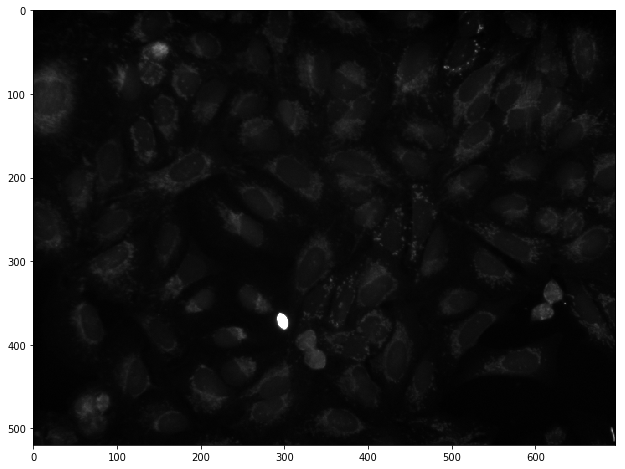

In [2]:
image = imread("data/test/test.tif", key=0)
plt.figure(figsize=(16,8))
plt.imshow(image, cmap='gray')
plt.show()

In [3]:
dim = image.shape
print(dim)

(520, 696)


### 1.1. Depth of field (DOF)

For each well in the plate, there are $9$ images taken in $9$ different DOF.

In [4]:
# Load the 9 images
imgs = []
for i in range(1, 10):
    imgs.append(imread("data/test/dof/dof{}.tif".format(i), key=0))

# Stack 9 images together
combi = np.vstack(
    (
        np.hstack((imgs[0], imgs[1], imgs[2])),
        np.hstack((imgs[3], imgs[4], imgs[5])),
        np.hstack((imgs[6], imgs[7], imgs[8]))
    )
)

# Draw white borders
thickness = 2
cv2.line(combi, (0, dim[0]), (dim[1]*3-1, dim[0]), 4096, thickness)
cv2.line(combi, (0, dim[0]*2-1), (dim[1]*3-1, dim[0]*2-1), 4096, thickness)
cv2.line(combi, (dim[1], 0), (dim[1], dim[0]*3-1), 4096, thickness)
cv2.line(combi, (dim[1]*2-1, 0), (dim[1]*2-1, dim[0]*3-1), 4096, thickness);

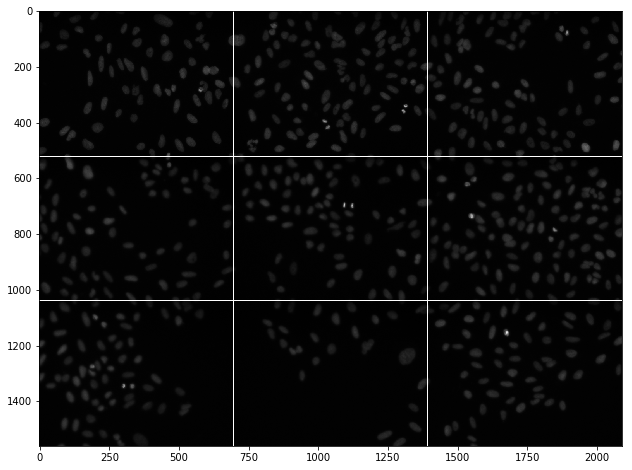

In [5]:
plt.figure(figsize=(16,8))
plt.imshow(combi, cmap='gray')
plt.show()

###  1.2. Channels

Each well image has five channels. We can try to merge some of those channels to visualize the images.

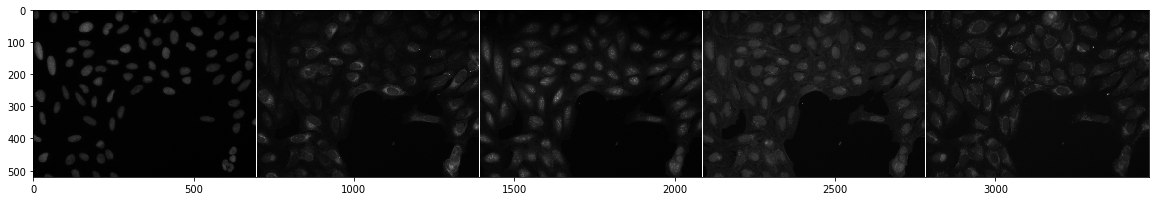

In [47]:
# Load 5 images
imgs = []
for i in range(1, 6):
    imgs.append(imread("data/test/channel/c{}.tif".format(i), key=0))

height = imgs[0].shape[0]
width = imgs[0].shape[1]

# Display 5 images side by side
combi = np.hstack(imgs)

# Add white borders
for i in range(1,5):
    cv2.line(combi, (i*width, 0), (i*width, height), 4096, thickness)

plt.figure(figsize=(20,20))
plt.imshow(combi, cmap="gray")
plt.show()

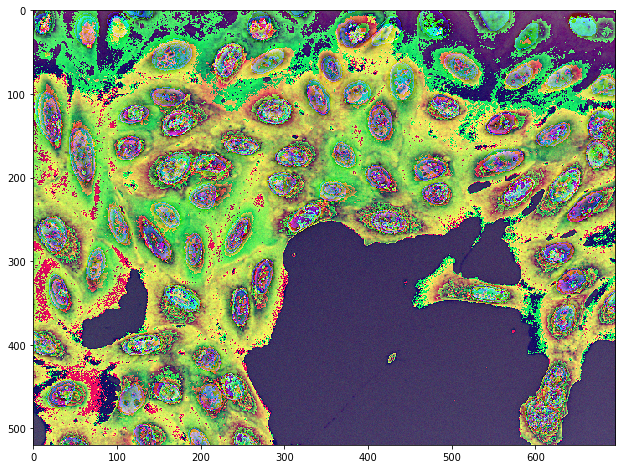

True

In [56]:
# Display the first three channels
# Be careful with the channel order; openCV is using BGR
merged_123 = cv2.merge((imgs[2], imgs[1], imgs[0]))
merged_123_float = merged_123.astype(float)

plt.figure(figsize=(16,8))
plt.imshow(merged_123_float)
plt.show()

# Save image
cv2.imwrite('./plots/c123.tif', merged_123)

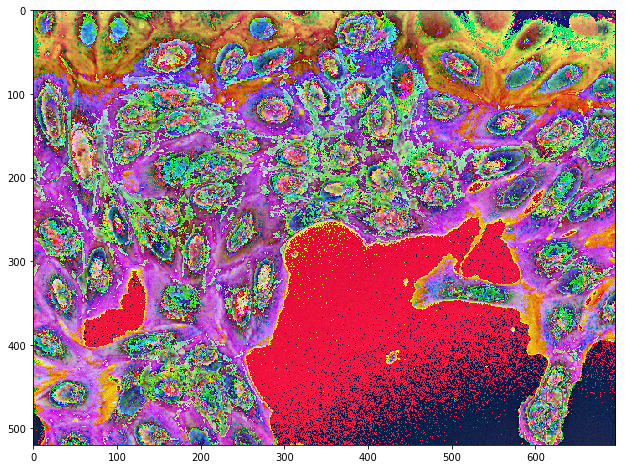

True

In [58]:
# Display the last three channels
merged_345 = cv2.merge((imgs[4], imgs[3], imgs[2]))
merged_345_float = merged_345.astype(float)

plt.figure(figsize=(16,8))
plt.imshow(merged_345_float)
plt.show()

# Save image
cv2.imwrite('./plots/c345.tif', merged_345)

## 2. Intensity Fix

I found the original intensity level of each pixel is too low for a 16-bit format image, so they show up as black pixels using the default "16-bit scale mapping". `matplotlib` changes its mapping based on the image matrix, so we can see the content.

Another probability is that Broad Institute is using a variant of 16-bit image format. Quoting from [Wikipedia](https://en.wikipedia.org/wiki/Color_depth#cite_note-7):

>In 16-bit direct color, there can be 4 bits (16 possible levels) for each of the R, G, and B components, plus optionally 4 bits for alpha (transparency), enabling 4,096 (16 × 16 × 16) different colors with 16 levels of transparency.
>
> Or in some systems there can be 5 bits per color component and 1 bit of alpha (32,768 colors, just fully transparent or not); or there can be 5 bits for red, 6 bits for green, and 5 bits for blue, for 65,536 colors with no transparency.

Based on the distribution of intensity, Broad Institute might be using the 4096 depth 16-bit format (I don't know why they need alpha channel for photography). What Photoshop does is to convert it to 65536 depth 16-bit format.

In [13]:
original = imread("./data/test/test.tif")
ps_fixed = imread("./data/test/test_ps.tif")
comb = np.hstack((original, ps_fixed))

In [19]:
original

array([[257, 250, 261, ..., 241, 225, 245],
       [238, 248, 247, ..., 229, 241, 228],
       [255, 243, 239, ..., 230, 235, 235],
       ...,
       [300, 310, 318, ..., 294, 277, 290],
       [317, 332, 318, ..., 280, 282, 266],
       [314, 319, 333, ..., 281, 280, 277]], dtype=uint16)

In [20]:
ps_fixed

array([[3126, 3038, 3200, ..., 2806, 2658, 2856],
       [2896, 3002, 3008, ..., 2690, 2812, 2682],
       [3064, 2946, 2912, ..., 2690, 2754, 2758],
       ...,
       [5146, 5426, 5668, ..., 4530, 4176, 4472],
       [5536, 5910, 5658, ..., 4174, 4224, 3874],
       [5442, 5634, 6012, ..., 4188, 4144, 4104]], dtype=uint16)

In [21]:
ps_fixed / original

array([[12.16342412, 12.152     , 12.2605364 , ..., 11.64315353,
        11.81333333, 11.65714286],
       [12.16806723, 12.10483871, 12.17813765, ..., 11.74672489,
        11.66804979, 11.76315789],
       [12.01568627, 12.12345679, 12.18410042, ..., 11.69565217,
        11.71914894, 11.73617021],
       ...,
       [17.15333333, 17.50322581, 17.82389937, ..., 15.40816327,
        15.07581227, 15.42068966],
       [17.4637224 , 17.80120482, 17.79245283, ..., 14.90714286,
        14.9787234 , 14.56390977],
       [17.33121019, 17.66144201, 18.05405405, ..., 14.90391459,
        14.8       , 14.81588448]])

We can see the intensity level changes after modification of Photoshop. The change is not linear, so if we decide to rescale the intensity we need to figure out how Photoshop does this.

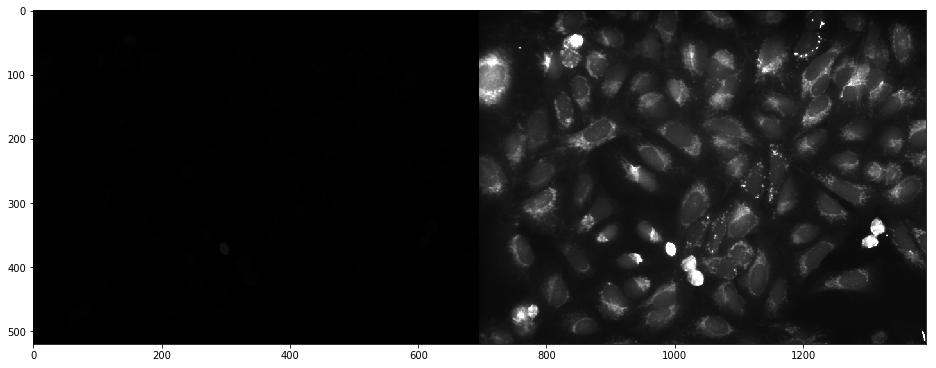

In [15]:
plt.figure(figsize=(16,8))
plt.imshow(comb, cmap='gray')
plt.show()

If we concatenate two image matrices, `matplotlib` adapts the scale of the PS fixed version so the original becomes black again (on the left).

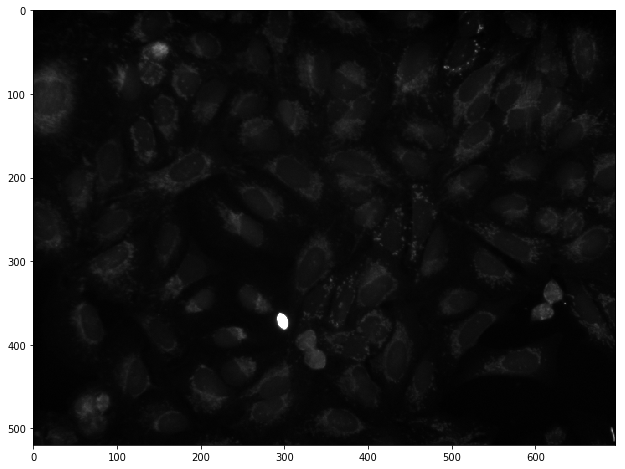

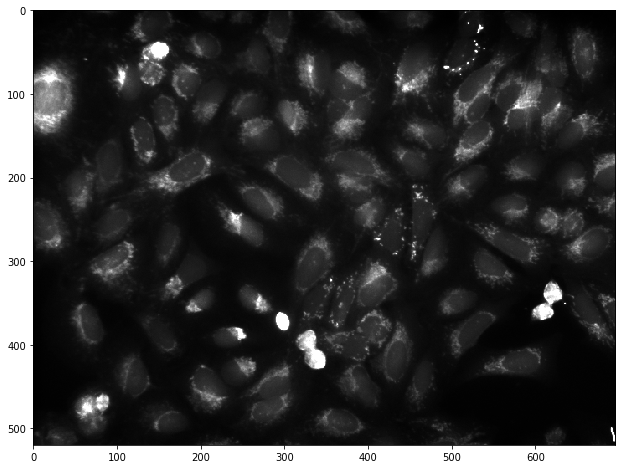

In [29]:
plt.figure(figsize=(16,8))
plt.imshow(original, cmap='gray')
plt.show()
plt.figure(figsize=(16,8))
plt.imshow(ps_fixed, cmap='gray')
plt.show()

If we plot them one by one, then we can see a difference. I believe the fixed image is more closed to the real result from Broad Institute.

### 2.1. Intensity fixed DOF

In [33]:
# Load the 9 images
imgs = []
for i in range(1, 10):
    imgs.append(imread("data/test/ps_fixed/dof/dof{}.tif".format(i), key=0))

# Stack 9 images together
combi = np.vstack(
    (
        np.hstack((imgs[0], imgs[1], imgs[2])),
        np.hstack((imgs[3], imgs[4], imgs[5])),
        np.hstack((imgs[6], imgs[7], imgs[8]))
    )
)

# Draw white borders
thickness = 2
cv2.line(combi, (0, dim[0]), (dim[1]*3-1, dim[0]), 65536, thickness)
cv2.line(combi, (0, dim[0]*2-1), (dim[1]*3-1, dim[0]*2-1), 65536, thickness)
cv2.line(combi, (dim[1], 0), (dim[1], dim[0]*3-1), 65536, thickness)
cv2.line(combi, (dim[1]*2-1, 0), (dim[1]*2-1, dim[0]*3-1), 65536, thickness);

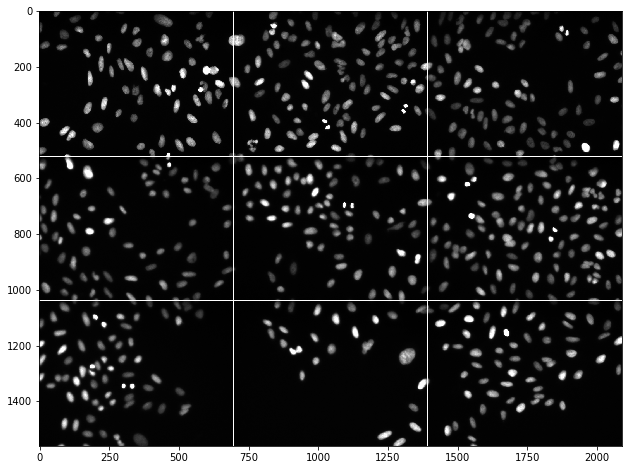

In [34]:
plt.figure(figsize=(16,8))
plt.imshow(combi, cmap='gray')
plt.show()

### 2.2. Channels

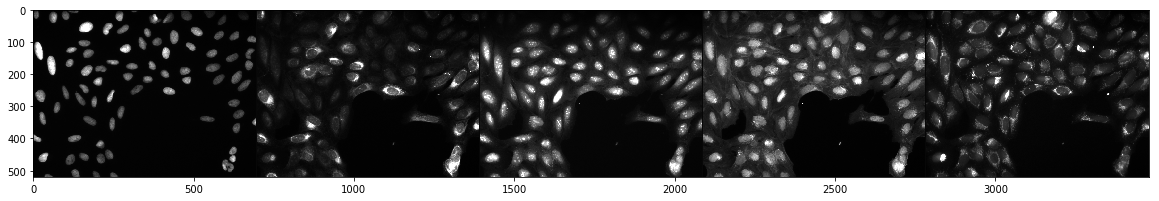

In [35]:
# Load 5 images
imgs = []
for i in range(1, 6):
    imgs.append(imread("data/test/ps_fixed/channel/c{}.tif".format(i), key=0))

height = imgs[0].shape[0]
width = imgs[0].shape[1]

# Display 5 images side by side
combi = np.hstack(imgs)

# Add white borders
for i in range(1,5):
    cv2.line(combi, (i*width, 0), (i*width, height), 4096, thickness)

plt.figure(figsize=(20,20))
plt.imshow(combi, cmap="gray")
plt.show()

In [45]:
# Display the first three channels
# Be careful with the channel order: openCV is using BGR
merged_123 = cv2.merge((imgs[2], imgs[1], imgs[0]))
merged_345 = cv2.merge((imgs[4], imgs[3], imgs[2]))

cv2.imwrite('./plots/c123_fixed.tif', merged_123)
cv2.imwrite('./plots/c345_fixed.tif', merged_345)

# plt.figure(figsize=(16,8))
# plt.imshow(merged_123)
# plt.show()

True

It turns out `matplotlib` only support plotting 8-bit RGB images. Therefore, I just merge those images then link them into this notebook.

One also can use `imagemagic`, a command line too for imaging, to make RGB visualizations. The result is the same as using openCV.

```shell
convert c1.tif c2.tif c3.tif -combine -set colorspace sRGB c123.tif
convert c3.tif c4.tif c5.tif -combine -set colorspace sRGB c345.tif
```

Then we get those beautiful images!

<p align="center">
    <img src="./plots/c123_fixed.tif">
    <center><em>Channel 1, 2, 3 as RGB</em></center>
</p>

<p align="center">
    <img src="./plots/c345_fixed.tif">
    <center><em>Channel 3, 4, 5 as RGB</em></center>
</p>

### 2.3. Revisit the original channels

Before fixing each channels, we have also saved the merged image in the original format. As expected, they are all black. Let's see if we can use Photoshop to fix them.

<p align="center">
    <img src="./plots/c123_ps_fixed.tif">
    <center><em>Channel 1, 2, 3 as RGB</em></center>
</p>

<p align="center">
    <img src="./plots/c345_ps_fixed.tif">
    <center><em>Channel 3, 4, 5 as RGB</em></center>
</p>

We can see compared to merging from five fixed grayscale images, fixing after merging give a less saturated image. We can't tell which one is "correct".